In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 权重衰减
之前提到了过一使用正则化来解决过拟合问题, 这里介绍的权重衰减就是一种正则化技术

在多项式回归的例子中, 可以通过限制多项式的阶数的方法来限制模型的容量(其实是限制模型的复杂度), 限制特征的数量是环节过拟合的一种方法, 在一个多项式函数中, 对于阶数为 $d$ 的项, 如果有 $k$ 个变量, 那么阶数为 $d$ 的项总共有 $\dbinom{d + k - 1}{k - 1}$ 种(可以自己使用隔板法进行求解), 所以随着阶数 $d$ 的增加, 模型的复杂度大幅上升, 所以需要控制函数的复杂性

**补充知识**:
$L_p$范数的表达式如下(其中 $L_1$范数和 $L_2$范数都是 $L_p$范数的特例):
$$
\|\mathbf{x}\|_p = \left( \sum_{i=1}^n |x_i|^p \right)^{1/p}
$$

在训练参数化机器学习模型的时候, 权重衰退是广泛使用的正则化技术之以, 也叫做 $L_2$正则化, 可以通过函数与 `0` 的记录来衡量函数的复杂度

一个自然的想法就是通过线性函数 $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}$ 中的权重向量的某一个泛数来度量复杂性, 比如 $\|\mathbf{w}\|^2$, 平方损失函数如下:
$$
L(\mathbf{w}, b) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{2} \left( \mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)} \right)^2
$$
此时可以加入权重的 **$L_2$ 范数**,所以这样就可以得到一个新的损失函数如下(其中 $\lambda$ 是一个超参数:
$$
L(\mathbf{w}, b) + \frac{\lambda}{2}\|\mathbf{w}\|^2
$$

**Q1: 这里为什么选择 $L_2$ 范数而不选择 $L_1$范数?**:  $L_2$正则化线性模型构成经典的岭回归算法, $L_1$正则化线性回归时统计学中类似的基本模型叫做套索回归, 使用 $L_2$范是的一个原因是对于权重向量的大分量时加了很大的乘法, 使得算法偏向于在大量特征上均匀分布权重的模型, $L_1$乘法可能会导致模型将权重集中在一小部分特征熵, 并且把其他权重清除为 $0$

在 $L_2$正则化回归的小批量随机梯度下降更新如下:
$$
\mathbf{w} \leftarrow (1 - \eta \lambda) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left( \mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)} \right)
$$

**Q2: 为什么叫做权重衰减?**: 从这里的损失函数可以看出, 训练过程中的目标是一方面降低损失, 另外一方面降低权重大小(权重的 $L_2$ 范数字作为惩罚项), 同时可以调整正则化参数($\lambda$)从而来调整对于 $\mathbf{w}$ 的约束, 同时也可以利用惩罚项对于偏置 $b^2$ 进行约束(但是我感觉偏置应该无法影响模型的复杂度, 所以这里可能不需要对于偏置进行约束?)

## 权重衰退验证

### 高维线性回归
考虑使用如下公式生成数据:
$$
y = 0.05 + \sum_{i=1}^{d} 0.01 x_i + \epsilon \ \text{where} \ \epsilon \sim \mathcal{N}(0, 0.01^2).
$$

In [4]:
# 数据集生成
# 训练集大小, 测试集大小, 输入数量, 批量
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1))*0.01, 0.03
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 从零开始实现

In [5]:
# 1. 初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [7]:
# 2. 定义 L2 范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

In [12]:
# 3. 开始模型训练
# lambda 表示正则化参数
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss # 线性回归模型, 平方损失函数
    num_epochs, lr = 100, 0.03
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
                            xlim=[5, num_epochs], legend=['train, test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    (d2l.evaluate_loss(net, test_iter, loss))))
    print('w的L2范数为: ', torch.norm(w).item()) # norm 为计算范数, 带平方根

#### 忽略正则化直接训练

w的L2范数为:  13.227584838867188


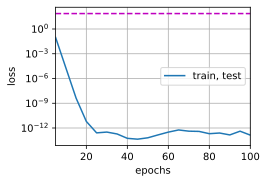

In [14]:
train(lambd=0) # 可以发现此时 w 的值很大, 发生了过拟合

#### 使用权重衰减

w的L2范数为:  0.03274038806557655


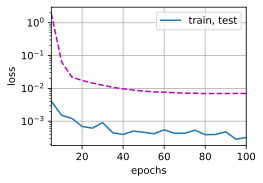

In [17]:
train(lambd=3)

### 简洁实现

In [20]:
# 训练过程, 使用 PyTorch API
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 优化器中设置 L2 范数惩罚
    trainer = torch.optim.SGD([
        {'params': net[0].weight, 'weight_decay': wd}, # 定义 L2 范数
        {'params': net[0].bias}
    ], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                           xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.mean().backward()
            trainer.step()
        if (epoch+1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    (d2l.evaluate_loss(net, test_iter, loss))))
    print('w的L2范数:', net[0].weight.norm().item())

w的L2范数: 12.697977066040039


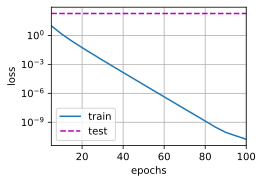

In [21]:
# 没有权重衰减
train_concise(0)

w的L2范数: 0.41756442189216614


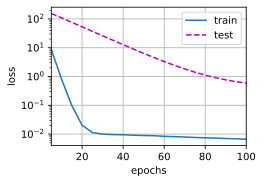

In [23]:
# 权重衰退
train_concise(3)

## 权重衰退中正则化参数的影响

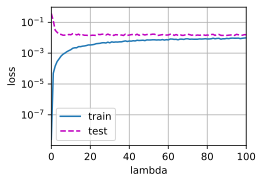

In [35]:
min_wd, max_wd = 0, 100
animator = d2l.Animator(xlabel='lambda', ylabel='loss', yscale='log',
                           xlim=[min_wd, max_wd], legend=['train', 'test'])
def train_without_draw(wd):
    num_epochs = 50
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    loss = nn.MSELoss(reduction='none')
    lr = 0.003
    trainer = torch.optim.SGD([
        {'params': net[0].weight, 'weight_decay': wd}, # 定义 L2 范数
        {'params': net[0].bias}
    ], lr=lr)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.mean().backward()
            trainer.step()
        if epoch == num_epochs - 1:
            animator.add(wd, (d2l.evaluate_loss(net, train_iter, loss),
                                    (d2l.evaluate_loss(net, test_iter, loss))))


for wd in range(min_wd, max_wd + 1):
    train_without_draw(wd)

## 补充
在使用其他的不同方法的时候也是可以存在正则化项, 比如:
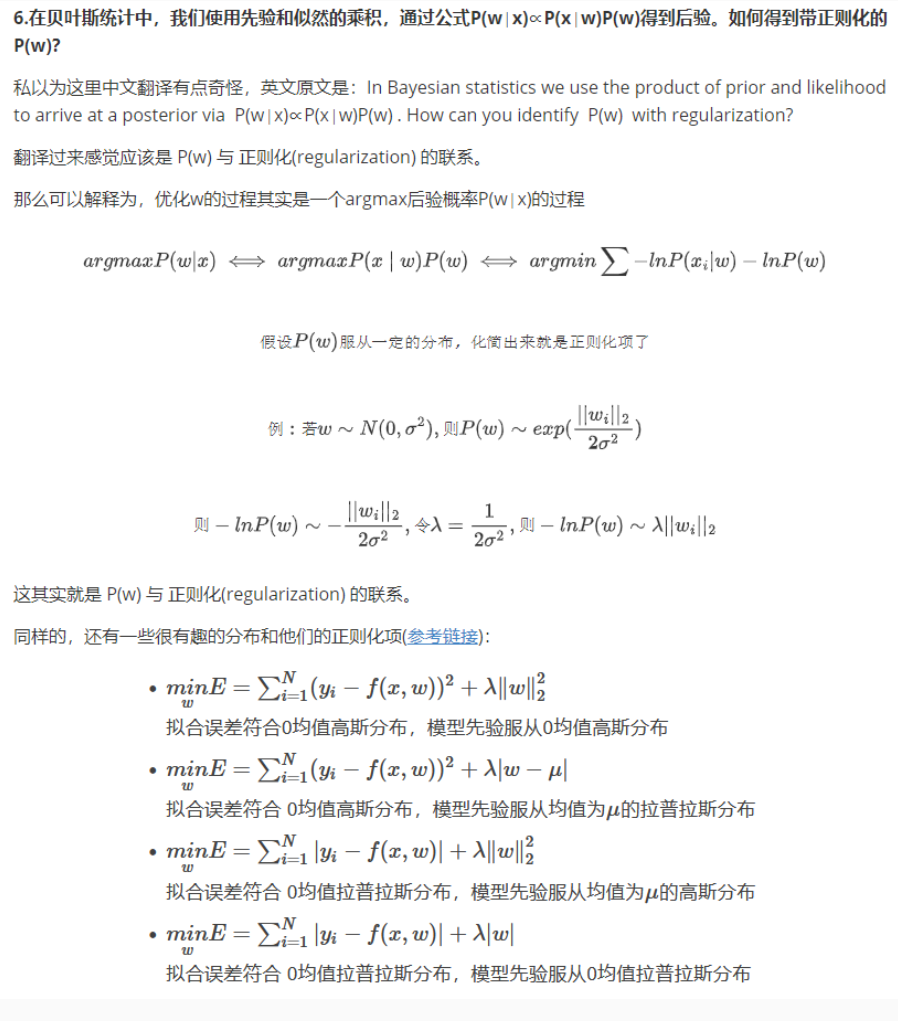